<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('yxz', x[0][0], degrees=True)

In [ ]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'implemented validation during training. try increasing n_critic. check https://www.sciencedirect.com/science/article/pii/S240595952100179X#b6'

In [ ]:
! git add .

In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 126.83 KiB | 7.93 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   bd21b85..c461aaf  main -> main


In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from tools import Metrics
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [4]:
# path is the path to the dataset
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=400, validation=0.1)
# dataset = Dataset(["sadness"], path=dataset_dir, step_size=10, frames=400, validation=0.1)

anger


100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


joy


100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


fear


100%|██████████| 4/4 [00:00<00:00,  7.86it/s]


neutral


100%|██████████| 9/9 [00:00<00:00,  9.10it/s]


sadness


100%|██████████| 5/5 [00:00<00:00,  9.20it/s]


pride


100%|██████████| 3/3 [00:00<00:00,  8.32it/s]


In [5]:
Dataset.balance(dataset)

No. of samples in each class will be:  595


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/one_class_2022.02.27-15:51:28

In [34]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset.frames, dataset.n_features),  # because sin and cos values for each value
        'n_classes' : dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 256,
        'n_critic' : 1,
        'dataset_balanced' : True,
        'critic_batch_norm' : False,
        'critic_instance_norm' : False,
        'critic_layer_norm' : True,
        'critic_weight_norm' : False,
        'critic_cond_layer_norm' : False,
        'generator_batch_norm' : False,
        'generator_layer_norm' : False,
        'generator_layer_norm_plus' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0,      # for the gradient penalty used in critic
        'smoothen' : False,
        'note' : 'only critic',
        'validation' : True,
        'only_critic' : False
      }

In [ ]:
! mkdir /content/drive/MyDrive/CS490/logs/

In [35]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

In [36]:
generator = define_norm_generator(config)

In [37]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset, outputs_path, 'validation_', critic, generator)

In [38]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [ ]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/one_class_2022.02.28-13:42:08/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

>1, 1/13, c_loss=4.402, g_loss=0.002, val_loss=-0.013
>1, 2/13, c_loss=3.915, g_loss=0.005, val_loss=-0.054
>1, 3/13, c_loss=3.126, g_loss=-0.001, val_loss=0.002
>1, 4/13, c_loss=2.705, g_loss=-0.004, val_loss=-0.020
>1, 5/13, c_loss=2.124, g_loss=-0.009, val_loss=-0.020
>1, 6/13, c_loss=1.665, g_loss=-0.019, val_loss=-0.007
>1, 7/13, c_loss=1.182, g_loss=-0.019, val_loss=-0.024
>1, 8/13, c_loss=0.851, g_loss=-0.051, val_loss=-0.008
>1, 9/13, c_loss=0.607, g_loss=-0.044, val_loss=-0.012
>1, 10/13, c_loss=0.419, g_loss=-0.054, val_loss=-0.012
>1, 11/13, c_loss=0.395, g_loss=-0.074, val_loss=0.006
>1, 12/13, c_loss=0.321, g_loss=-0.082, val_loss=0.007
>1, 13/13, c_loss=0.253, g_loss=-0.118, val_loss=0.013


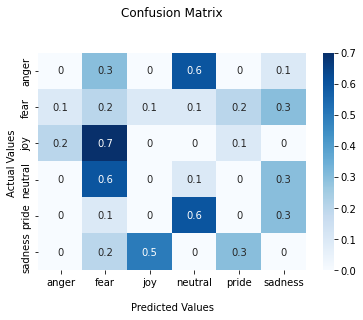

>2, 1/13, c_loss=0.322, g_loss=-0.088, val_loss=0.017
>2, 2/13, c_loss=0.234, g_loss=-0.149, val_loss=0.023
>2, 3/13, c_loss=0.414, g_loss=-0.173, val_loss=0.010
>2, 4/13, c_loss=0.345, g_loss=-0.231, val_loss=0.008
>2, 5/13, c_loss=0.401, g_loss=-0.223, val_loss=-0.010
>2, 6/13, c_loss=0.405, g_loss=-0.209, val_loss=0.022
>2, 7/13, c_loss=0.511, g_loss=-0.260, val_loss=0.033
>2, 8/13, c_loss=0.513, g_loss=-0.264, val_loss=-0.003
>2, 9/13, c_loss=0.511, g_loss=-0.461, val_loss=0.009
>2, 10/13, c_loss=0.509, g_loss=-0.461, val_loss=0.016
>2, 11/13, c_loss=0.487, g_loss=-0.463, val_loss=-0.005
>2, 12/13, c_loss=0.617, g_loss=-0.512, val_loss=-0.004
>2, 13/13, c_loss=0.688, g_loss=-0.554, val_loss=-0.002


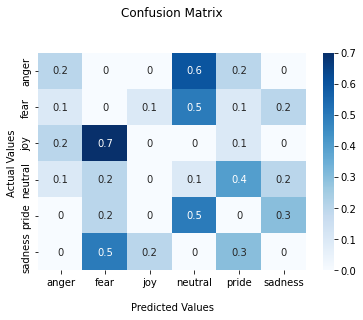

>3, 1/13, c_loss=0.665, g_loss=-0.704, val_loss=0.015
>3, 2/13, c_loss=0.843, g_loss=-0.712, val_loss=0.005
>3, 3/13, c_loss=0.863, g_loss=-0.750, val_loss=0.007
>3, 4/13, c_loss=0.864, g_loss=-0.762, val_loss=-0.010
>3, 5/13, c_loss=0.839, g_loss=-0.790, val_loss=-0.007
>3, 6/13, c_loss=0.814, g_loss=-0.753, val_loss=0.000
>3, 7/13, c_loss=0.906, g_loss=-0.700, val_loss=-0.005
>3, 8/13, c_loss=0.849, g_loss=-0.690, val_loss=-0.009
>3, 9/13, c_loss=0.786, g_loss=-0.732, val_loss=-0.008
>3, 10/13, c_loss=0.814, g_loss=-0.755, val_loss=-0.020
>3, 11/13, c_loss=0.799, g_loss=-0.695, val_loss=0.000
>3, 12/13, c_loss=0.787, g_loss=-0.700, val_loss=-0.008
>3, 13/13, c_loss=0.755, g_loss=-0.701, val_loss=-0.003


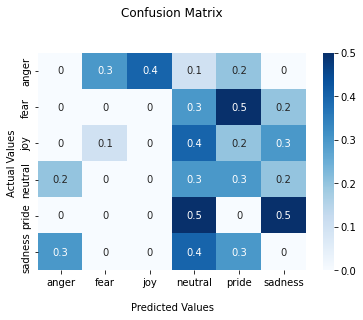

>4, 1/13, c_loss=0.753, g_loss=-0.682, val_loss=-0.007
>4, 2/13, c_loss=0.762, g_loss=-0.636, val_loss=0.003
>4, 3/13, c_loss=0.714, g_loss=-0.683, val_loss=-0.005
>4, 4/13, c_loss=0.729, g_loss=-0.636, val_loss=-0.023
>4, 5/13, c_loss=0.692, g_loss=-0.631, val_loss=-0.018
>4, 6/13, c_loss=0.709, g_loss=-0.600, val_loss=-0.025
>4, 7/13, c_loss=0.648, g_loss=-0.626, val_loss=-0.017
>4, 8/13, c_loss=0.605, g_loss=-0.582, val_loss=-0.041
>4, 9/13, c_loss=0.608, g_loss=-0.573, val_loss=-0.045
>4, 10/13, c_loss=0.611, g_loss=-0.576, val_loss=-0.025
>4, 11/13, c_loss=0.611, g_loss=-0.543, val_loss=-0.013
>4, 12/13, c_loss=0.609, g_loss=-0.539, val_loss=-0.032
>4, 13/13, c_loss=0.616, g_loss=-0.501, val_loss=-0.023


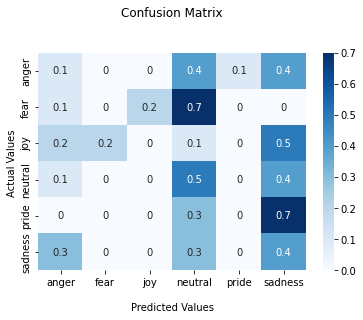

>5, 1/13, c_loss=0.567, g_loss=-0.495, val_loss=-0.017
>5, 2/13, c_loss=0.539, g_loss=-0.464, val_loss=-0.027
>5, 3/13, c_loss=0.505, g_loss=-0.466, val_loss=-0.010
>5, 4/13, c_loss=0.481, g_loss=-0.410, val_loss=-0.024
>5, 5/13, c_loss=0.468, g_loss=-0.405, val_loss=-0.012
>5, 6/13, c_loss=0.440, g_loss=-0.383, val_loss=-0.000
>5, 7/13, c_loss=0.458, g_loss=-0.382, val_loss=-0.019
>5, 8/13, c_loss=0.408, g_loss=-0.385, val_loss=-0.014
>5, 9/13, c_loss=0.425, g_loss=-0.357, val_loss=0.005
>5, 10/13, c_loss=0.381, g_loss=-0.344, val_loss=-0.024
>5, 11/13, c_loss=0.383, g_loss=-0.356, val_loss=-0.028
>5, 12/13, c_loss=0.382, g_loss=-0.342, val_loss=-0.037
>5, 13/13, c_loss=0.357, g_loss=-0.318, val_loss=-0.026


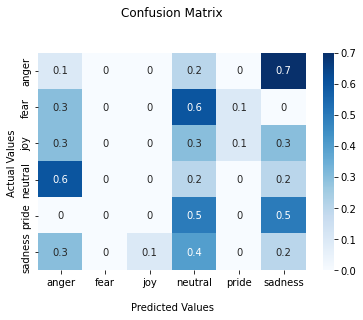

>6, 1/13, c_loss=0.337, g_loss=-0.303, val_loss=-0.014
>6, 2/13, c_loss=0.325, g_loss=-0.265, val_loss=-0.017
>6, 3/13, c_loss=0.318, g_loss=-0.294, val_loss=-0.007
>6, 4/13, c_loss=0.275, g_loss=-0.264, val_loss=-0.007
>6, 5/13, c_loss=0.290, g_loss=-0.264, val_loss=0.014
>6, 6/13, c_loss=0.203, g_loss=-0.235, val_loss=-0.037
>6, 7/13, c_loss=0.230, g_loss=-0.243, val_loss=-0.014
>6, 8/13, c_loss=0.208, g_loss=-0.219, val_loss=-0.043
>6, 9/13, c_loss=0.181, g_loss=-0.206, val_loss=-0.027
>6, 10/13, c_loss=0.159, g_loss=-0.176, val_loss=-0.032
>6, 11/13, c_loss=0.133, g_loss=-0.198, val_loss=-0.050
>6, 12/13, c_loss=0.145, g_loss=-0.219, val_loss=-0.035
>6, 13/13, c_loss=0.118, g_loss=-0.201, val_loss=-0.034


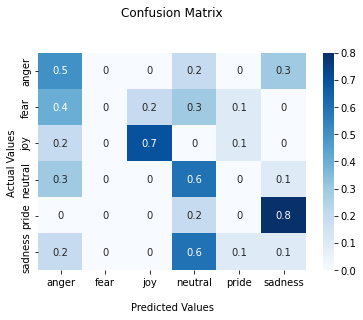

>7, 1/13, c_loss=0.181, g_loss=-0.226, val_loss=-0.019
>7, 2/13, c_loss=0.141, g_loss=-0.219, val_loss=-0.019
>7, 3/13, c_loss=0.141, g_loss=-0.199, val_loss=-0.011
>7, 4/13, c_loss=0.158, g_loss=-0.244, val_loss=0.004
>7, 5/13, c_loss=0.163, g_loss=-0.231, val_loss=-0.020
>7, 6/13, c_loss=0.187, g_loss=-0.281, val_loss=-0.029
>7, 7/13, c_loss=0.169, g_loss=-0.252, val_loss=-0.022
>7, 8/13, c_loss=0.205, g_loss=-0.276, val_loss=-0.029
>7, 9/13, c_loss=0.220, g_loss=-0.290, val_loss=-0.022
>7, 10/13, c_loss=0.207, g_loss=-0.313, val_loss=-0.016
>7, 11/13, c_loss=0.219, g_loss=-0.313, val_loss=-0.006
>7, 12/13, c_loss=0.190, g_loss=-0.300, val_loss=0.004
>7, 13/13, c_loss=0.211, g_loss=-0.304, val_loss=-0.027


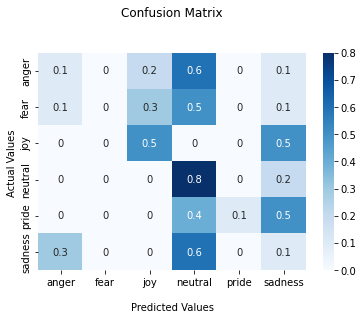

>8, 1/13, c_loss=0.224, g_loss=-0.330, val_loss=-0.005
>8, 2/13, c_loss=0.165, g_loss=-0.297, val_loss=-0.006
>8, 3/13, c_loss=0.178, g_loss=-0.322, val_loss=0.016
>8, 4/13, c_loss=0.155, g_loss=-0.337, val_loss=-0.006
>8, 5/13, c_loss=0.189, g_loss=-0.309, val_loss=0.001
>8, 6/13, c_loss=0.156, g_loss=-0.305, val_loss=-0.000
>8, 7/13, c_loss=0.205, g_loss=-0.326, val_loss=-0.023
>8, 8/13, c_loss=0.175, g_loss=-0.329, val_loss=-0.037
>8, 9/13, c_loss=0.184, g_loss=-0.332, val_loss=-0.005
>8, 10/13, c_loss=0.191, g_loss=-0.311, val_loss=-0.038
>8, 11/13, c_loss=0.202, g_loss=-0.320, val_loss=-0.020
>8, 12/13, c_loss=0.170, g_loss=-0.315, val_loss=-0.011
>8, 13/13, c_loss=0.196, g_loss=-0.320, val_loss=-0.014


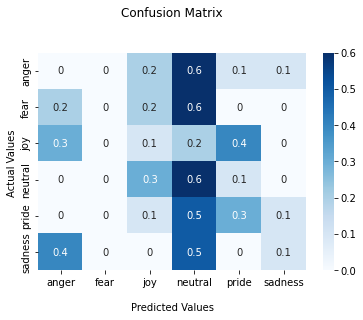

>9, 1/13, c_loss=0.196, g_loss=-0.313, val_loss=-0.034
>9, 2/13, c_loss=0.177, g_loss=-0.323, val_loss=-0.030
>9, 3/13, c_loss=0.145, g_loss=-0.342, val_loss=-0.047
>9, 4/13, c_loss=0.162, g_loss=-0.332, val_loss=-0.013
>9, 5/13, c_loss=0.200, g_loss=-0.326, val_loss=-0.025
>9, 6/13, c_loss=0.165, g_loss=-0.351, val_loss=-0.032
>9, 7/13, c_loss=0.201, g_loss=-0.318, val_loss=-0.006
>9, 8/13, c_loss=0.145, g_loss=-0.352, val_loss=-0.024
>9, 9/13, c_loss=0.194, g_loss=-0.376, val_loss=-0.040
>9, 10/13, c_loss=0.175, g_loss=-0.383, val_loss=-0.018
>9, 11/13, c_loss=0.181, g_loss=-0.385, val_loss=-0.038
>9, 12/13, c_loss=0.215, g_loss=-0.391, val_loss=-0.014
>9, 13/13, c_loss=0.215, g_loss=-0.357, val_loss=-0.046


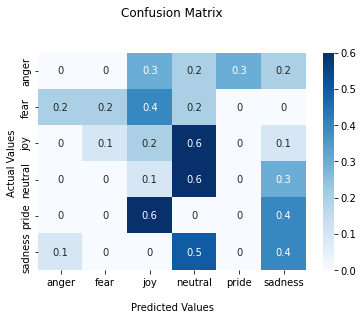

>10, 1/13, c_loss=0.183, g_loss=-0.363, val_loss=-0.014
>10, 2/13, c_loss=0.191, g_loss=-0.352, val_loss=-0.034
>10, 3/13, c_loss=0.174, g_loss=-0.341, val_loss=-0.023
>10, 4/13, c_loss=0.189, g_loss=-0.371, val_loss=-0.027
>10, 5/13, c_loss=0.163, g_loss=-0.362, val_loss=-0.025
>10, 6/13, c_loss=0.202, g_loss=-0.360, val_loss=-0.022
>10, 7/13, c_loss=0.195, g_loss=-0.362, val_loss=-0.014
>10, 8/13, c_loss=0.220, g_loss=-0.359, val_loss=-0.013
>10, 9/13, c_loss=0.172, g_loss=-0.352, val_loss=0.005
>10, 10/13, c_loss=0.178, g_loss=-0.372, val_loss=0.012
>10, 11/13, c_loss=0.191, g_loss=-0.367, val_loss=-0.024
>10, 12/13, c_loss=0.213, g_loss=-0.372, val_loss=0.014
>10, 13/13, c_loss=0.191, g_loss=-0.357, val_loss=0.001


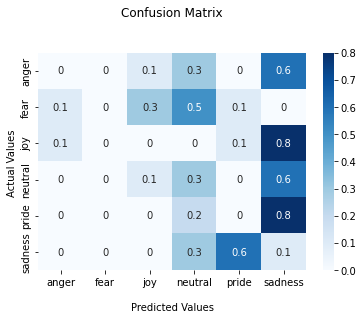

>11, 1/13, c_loss=0.226, g_loss=-0.377, val_loss=-0.003
>11, 2/13, c_loss=0.189, g_loss=-0.377, val_loss=0.006


In [ ]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

In [ ]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models'):
  if 'epoch_1' not in os.listdir('/content/drive/MyDrive/CS490/models/' + dir):
    ! rm -rf '/content/drive/MyDrive/CS490/models/' + dir

In [ ]:
labels = np.arange(6)

In [ ]:
class_names = np.array([dataset.ordinalencoder.inverse_transform([[labels[i]]]) for i in labels])

In [ ]:
cm = Metrics.confusion_matrix(critic=critic, n_classes=config['n_classes'], n_samples=10, dataset=dataset, smoothen=config['smoothen'], val=config['validation'])


In [ ]:
from tools import Tools

In [ ]:
Tools.draw_confusion_matrix(cm, class_names)

NameError: ignored

In [ ]:
import json
with open('/content/drive/MyDrive/CS490/models/only_critic_projection_wrong2022.04.14-20:38:27/epoch_4/cm.txt', 'r') as file:
  cm = json.load(file)

In [ ]:
np.array(cm) / 10

array([[0.2, 0.1, 0. , 0.1, 0. , 0.1],
       [0.1, 0.3, 0.1, 0. , 0.1, 0.1],
       [0.2, 0. , 0.4, 0. , 0. , 0. ],
       [0.1, 0. , 0.1, 0.5, 0. , 0.2],
       [0. , 0.5, 0.2, 0.1, 0.5, 0. ],
       [0.4, 0.1, 0.2, 0.3, 0.4, 0.6]])

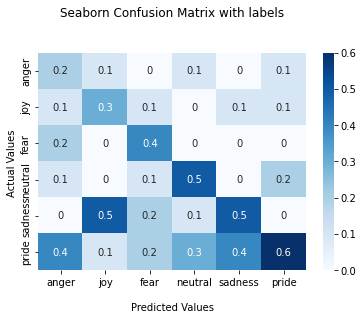

In [ ]:
import seaborn as sns

ax = sns.heatmap(np.array(cm) / 10, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["anger", "joy", "fear", "neutral", "sadness", "pride"])
ax.yaxis.set_ticklabels(["anger", "joy", "fear", "neutral", "sadness", "pride"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/only_critic_projection_wrong2022.04.14-20:33:46

In [ ]:
labels = np.array([0])
labels = np.repeat(labels, 1)
outputs = gan.generate(labels)

In [ ]:
x = outputs * 180

In [ ]:
outputs

array([[[ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        ...,
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ],
        [ 0.00899361, -0.01141282,  0.01145669, ..., -0.00974358,
          0.01140397, -0.0115169 ]]], dtype=float32)

In [ ]:
x[0][-1].min()

-184.65588

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/WGAN2022.02.26-15:19:21

In [ ]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models/models_smoothened_data'):
  # if dir[0:10] == 'WGAN_layer' and dir != 'WGAN2022.01.26-14:29:43':
  path = os.path.join('/content/drive/MyDrive/CS490/models/models_smoothened_data', dir)
  ! rm -rf $path

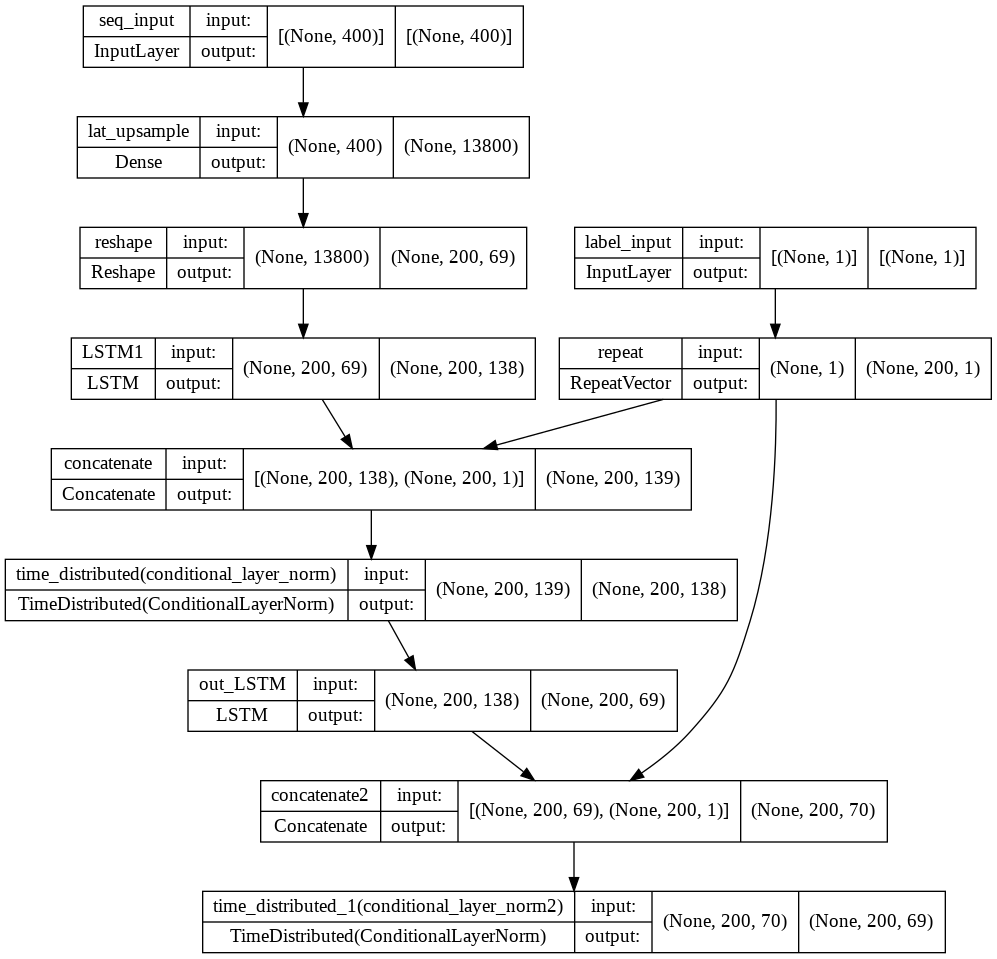

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 200, 138)     0           ['lat_upsample[0][0]']           
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:48:19/epoch_1', 'train_metrics.txt')) as file:
  tm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]

<function matplotlib.pyplot.figure>

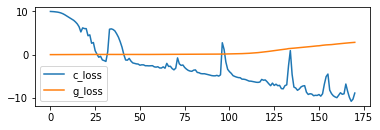

In [ ]:
Base_WGAN.plot_history(gan.train_metrics)

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'cm.txt')) as file:
  cm = json.load(file)

In [33]:
import os, sys, logging, json, re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import datetime, os
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model

main_dir = os.getcwd()
sys.path.append(main_dir)
from tools import Tools, Metrics
from models.generator_models.norm_generator import ConditionalBatchNorm, ConditionalLayerNormPlus, ConditionalLayerNorm

class Base_WGAN(keras.Model):
    def __init__(
        self,
        config,
        dataset,
        dest_dir = None,
        name = None,
        critic = None,
        generator = None, 
        model_load = None     # None or path to a specific epoch 
    ):
        super(Base_WGAN, self).__init__()
        self.dataset = dataset
        self.logger = logging.getLogger()
        self.logger.setLevel(logging.DEBUG)
        logging.basicConfig(filename="/content/test.log",
                    format='%(asctime)s %(message)s',
                    filemode='w')
        if model_load == None:
          self.config = config
          self.critic = critic
          if self.config['only_critic'] == False:
            self.generator = generator
          self.model_name = name + datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
          self.model_dir = os.path.join(dest_dir, self.model_name)
          self.train_metrics = [list() for i in range(3)]   # c_loss, g_loss
          self.start_epoch = 0
        else:
          self.model_dir = model_load[0:-len(os.path.basename(model_load))]
          with open(os.path.join(self.model_dir, 'config.json')) as file:
            self.config = json.load(file)
          if os.path.basename(model_load)[:5] != 'epoch':
            logging.error('model_load needs to be a path to an epoch folder, as in epoch_4.')
          self.critic = load_model(os.path.join(model_load, 'critic.h5'))
          if self.config['only_critic'] == False:
            if self.config['generator_batch_norm']:
              self.generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalBatchNorm':ConditionalBatchNorm})
            elif self.config['generator_layer_norm']:
              self.generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalLayerNorm':ConditionalLayerNorm})
            elif self.config['generator_layer_norm_plus']:
              self.generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalLayerNormPlus':ConditionalLayerNormPlus})
          self.model_dir = model_load[0:-len(os.path.basename(model_load))]
          with open(os.path.join(model_load, 'train_metrics.txt')) as file:
            self.train_metrics = json.load(file)
          self.start_epoch = int(re.match('.*?([0-9]+)$', model_load).group(1))
    def compile(self, c_optimizer, g_optimizer, c_loss_fn, g_loss_fn):
        super(Base_WGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_loss_fn = c_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_seq, real_labels, fake_seq):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, self.config['in_shape'][0], self.config['in_shape'][1],], 0.0, 1.0)
        diff = fake_seq - real_seq
        # self.logger.info('fake_seq: {}, real_seq: {}, diff: {}, alpha: {}'.format(fake_seq.shape, real_seq.shape, diff.shape, alpha.shape))
        interpolated = real_seq + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.critic([real_labels, interpolated], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    # logdir is the general destination path for the tensorflow board logs.
    def train(self, logdir=None, verbose=2):  #   for now no tensorboard
        if not os.path.exists(self.model_dir):
            self.logger.info('Creating new model directory.')
            os.mkdir(self.model_dir)
            with open(os.path.join(self.model_dir, 'config.json'), 'w') as file:
                json.dump(self.config, file)
            plot_model(self.critic, show_shapes=True, show_layer_names=True, to_file=os.path.join(self.model_dir, 'critic.png'))
            if self.config['only_critic'] == False:
              plot_model(self.generator, show_shapes=True, show_layer_names=True, to_file=os.path.join(self.model_dir, 'generator.png'))
        device_name = tf.test.gpu_device_name()
        if device_name == '/device:GPU:0':
            with tf.device('/device:GPU:0'):
                labels = np.arange(self.config['n_classes'])
                class_names = np.array([self.dataset.ordinalencoder.inverse_transform([[labels[i]]]) for i in labels])
                # tensorboard = tf.keras.callbacks.TensorBoard(os.path.join(logdir, self.name), histogram_freq=1)
                # tensorboard.set_model(self.critic)
                # tensorboard.set_model(self.generator)
                # TRAINING
                dataset_size = self.dataset.get_size()
                bat_per_epo = int(dataset_size / self.config['batch_size'])
                for epoch in range(self.start_epoch, self.config['epochs']):
                    # c_loss_epoch, g_loss_epoch = list(), list()
                    for batch in range(bat_per_epo):
                        c_loss_batch = 0
                        [labels_real, X_real], y_real = self.dataset.generate_real_samples(self.config['batch_size'], smoothen=self.config['smoothen'])
                        for _ in range(self.config['n_critic']):
                            # Get the latent vector
                            labels_input, z_input = Tools.generate_latent_points(self.config['latent_dim'], self.config['batch_size'], self.config['n_classes'])
                            with tf.GradientTape() as tape:
                                # Generate fake images from the latent vector
                                if self.config['only_critic'] == False:
                                  fake_samples = self.generator([labels_input, z_input], training=True)
                                else:
                                  [labels_input, fake_samples], y_fake = self.dataset.generate_fake_samples(self.config['batch_size'], smoothen=self.config['smoothen'])

                                # Get the logits for the fake samples
                                fake_logits = self.critic([labels_input, fake_samples], training=True)
                                # Get the logits for the real images
                                real_logits = self.critic([labels_real, X_real], training=True)

                                # Calculate the discriminator loss using the fake and real image logits
                                c_cost = self.c_loss_fn(real=real_logits, fake=fake_logits)
                                # Calculate the gradient penalty
                                gp = self.gradient_penalty(self.config['batch_size'], real_seq=X_real, real_labels=labels_real, fake_seq=fake_samples)
                                # Add the gradient penalty to the original discriminator loss
                                c_loss = c_cost + gp * self.config['gp_weight']
                                c_loss_batch += c_loss

                            # Get the gradients w.r.t the critic loss
                            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
                            # Update the weights of the discriminator using the discriminator optimizer
                            self.c_optimizer.apply_gradients(
                                zip(c_gradient, self.critic.trainable_variables)
                            )

                        # Train the generator
                        # Get the latent vector
                        if self.config['only_critic'] == False:
                          labels_input, z_input = Tools.generate_latent_points(self.config['latent_dim'], self.config['batch_size'], self.config['n_classes'])
                          with tf.GradientTape() as tape:
                              # Generate fake images using the generator
                              fake_samples = self.generator([labels_input, z_input], training=True)
                              # Get the discriminator logits for fake images
                              fake_logits = self.critic([labels_input, fake_samples], training=True)
                              # Calculate the generator loss
                              g_loss_batch = self.g_loss_fn(fake_logits)

                          # Get the gradients w.r.t the generator loss
                          gen_gradient = tape.gradient(g_loss_batch, self.generator.trainable_variables)
                          # Update the weights of the generator using the generator optimizer
                          self.g_optimizer.apply_gradients(
                              zip(gen_gradient, self.generator.trainable_variables)
                          )
                        else:
                          g_loss_batch = 0
                        if self.config['validation']:
                          [labels_real, X_real], y_real = self.dataset.generate_real_samples(self.config['batch_size'], smoothen=self.config['smoothen'], val=True)
                          [labels_input, fake_samples], y_fake = self.dataset.generate_fake_samples(self.config['batch_size'], smoothen=self.config['smoothen'], val=True)
                          fake_logits = self.critic([labels_input, fake_samples], training=False)
                          real_logits = self.critic([labels_real, X_real], training=False)
                          val_loss = self.c_loss_fn(real=real_logits, fake=fake_logits)
                          # g_loss batch is validation loss of critic if we run it in validation mode
                        else:
                          val_loss = 0
                        self.train_metrics[0].append(c_loss_batch / self.config['n_critic'])
                        self.train_metrics[1].append(g_loss_batch)
                        self.train_metrics[2].append(val_loss)
                        # c_loss_epoch.append(c_loss_batch / self.config['n_critic'])
                        # g_loss_epoch.append(g_loss_batch)
                        if verbose == 1 or verbose == 2:
                            print('>%d, %d/%d, c_loss=%.3f, g_loss=%.3f, val_loss=%.3f' %(epoch+1, batch+1, bat_per_epo, c_loss_batch / self.config['n_critic'], g_loss_batch, val_loss))
                    # logs = [mean(c_loss_epoch), mean(g_loss_epoch)]
                    # names = ["c_loss", "g_loss"]
                    # tensorboard.on_epoch_end(epoch+1, Tools.named_logs(names, logs))
                    epoch_dir = os.path.join(self.model_dir, 'epoch_' + str(epoch+1))
                    os.mkdir(epoch_dir)
                    if self.config['only_critic'] == False:
                      self.generator.save(os.path.join(epoch_dir, 'generator.h5'), include_optimizer=True)
                    self.critic.save(os.path.join(epoch_dir, 'critic.h5'), include_optimizer=True)
                    with open(os.path.join(epoch_dir, 'train_metrics.txt'), 'w') as file:
                        json.dump(np.array(self.train_metrics).tolist(), file)
                    if verbose == 2:
                      if self.config['only_critic'] == False:
                        self.save_checkpoint(epoch_dir, n_samples=1)
                      # apply on validation data
                      cm = Metrics.confusion_matrix(critic=self.critic, n_classes=self.config['n_classes'], n_samples=10, dataset=self.dataset, smoothen=self.config['smoothen'], val=self.config['validation'])
                      Tools.draw_confusion_matrix(cm, class_names)
                      with open(os.path.join(epoch_dir, 'cm.txt'), 'w') as file:
                        json.dump(cm, file)

        else:
          with tf.device('/cpu:0'):
            self.logger.error('Not connected to GPU')
    # create a line plot of loss for the gan and save to file
    @staticmethod
    def plot_history(train_metrics):
      # plot loss
      c_loss, g_loss = train_metrics
      plt.subplot(2, 1, 1)
      plt.plot(c_loss, label='c_loss')
      plt.plot(g_loss, label='g_loss')
      plt.legend()
      return plt.figure

    # use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self, n_samples):
      # generate points in latent space
      labels_input, z_input = Tools.generate_latent_points(self.latent_dim, n_samples, self.n_classes)
      # predict outputs
      seq = self.generator.predict([labels_input, z_input])
      # create class labels
      y = np.ones((n_samples, 1))
      return [labels_input, tf.convert_to_tensor(seq, dtype=tf.float32)], tf.convert_to_tensor(y, dtype=tf.float32)

    def generate(self, labels):
      [labels_input, z_input] = Tools.generate_latent_points(self.config['latent_dim'], labels.shape[0], self.config['n_classes'])
      outputs = self.generator.predict([labels, z_input])
      return outputs

    # generate n_samples per label and save as images
    def save_checkpoint(self, epoch_dir, n_samples=3):
      # prepare fake examples
      labels = np.arange(self.config['n_classes'])
      labels = np.repeat(labels, n_samples)
      outputs = self.generate(labels)
      # visualize and plot poses
      position_transformed = []
      for i in range(outputs.shape[0]):
        position_transformed.append(self.dataset.transform(np.array([outputs[i]]), smoothen=self.config['smoothen'])[0])
      for i, mocap_track in enumerate(position_transformed):
        fig = self.dataset.stickfigure(mocap_track, step=20, cols=5, title=self.dataset.ordinalencoder.inverse_transform([[labels[i]]]), figsize=(8,8))
        fig.savefig(os.path.join(epoch_dir, str(i) + '.png'))
        plt.close()